In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# check GPU  (I got a Tesla P100 today)
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [4]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

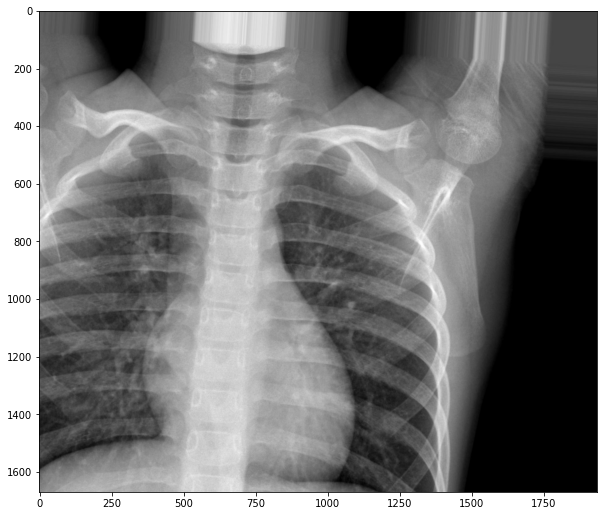

In [5]:
# simply show a picture
plt.figure(figsize= (10, 10))
img = mpimg.imread("../input/lungs-disease-dataset-4-types/Lung Disease Dataset/train/Normal/test_0_9774.jpeg")
plt.imshow(img)
plt.show()

In [7]:
# ImageDataGenerator (only can adjust on training data)
traingen = ImageDataGenerator(rescale= 1./255,
                             width_shift_range=0.2 , 
                             height_shift_range=0.2 ,
                             zoom_range=0.2)
valgen = ImageDataGenerator(rescale= 1./255)
testgen = ImageDataGenerator(rescale= 1./255)

In [8]:
# flow_from_directory
train_it = traingen.flow_from_directory("../input/lungs-disease-dataset-4-types/Lung Disease Dataset/train", target_size = (224, 224))
val_it = traingen.flow_from_directory("../input/lungs-disease-dataset-4-types/Lung Disease Dataset/val", target_size = (224, 224))
test_it = traingen.flow_from_directory("../input/lungs-disease-dataset-4-types/Lung Disease Dataset/test", target_size = (224, 224))


Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


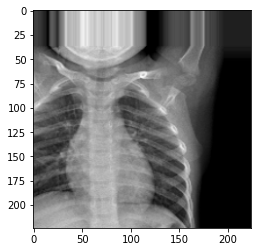

In [9]:
# show the picture after ImageDataGenerator
plt.figure()
plt.imshow(next(train_it)[0][0])
plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

# Use pre-trained model of DenseNet201
base_model_201 = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3),
    include_top=False,
    weights=None  # Set to None since we will load the weights manually
)

# Load weights from a local file
base_model_201.load_weights("/kaggle/input/weight-file-densenet201/densenet201_weights_tf_dim_ordering_tf_kernels_notop (1).h5")

# Lock layers
for layer in base_model_201.layers:
    layer.trainable = False

# Set up fully connected layers
x = layers.Flatten()(base_model_201.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(5, activation='softmax')(x)

# Create the model
model2 = tf.keras.models.Model(base_model_201.input, x)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# use checkpoint to save the best model
# use ReduceLROnPlateau to automaticly turn down learning rate
Checkpoint = tf.keras.callbacks.ModelCheckpoint("densenet201.hdf5", monitor="val_acc", save_best_only= True, mode="max")
reduce_lr = ReduceLROnPlateau(monitor= "val_acc", factor= 0.5, patience= 4, verbose= 3,cooldown=2,  mode= "max", min_lr= 0.0000001)

model2.fit(train_it, validation_data= val_it, epochs=100, callbacks= [reduce_lr, Checkpoint], steps_per_epoch=60, validation_steps=10)

Epoch 1/100
60/60 [==============================] - 261s 4s/step - loss: 6.1461 - acc: 0.6325 - val_loss: 1.1550 - val_acc: 0.7125
Epoch 2/100
60/60 [==============================] - 245s 4s/step - loss: 1.1598 - acc: 0.7307 - val_loss: 1.1045 - val_acc: 0.7344
Epoch 3/100
60/60 [==============================] - 245s 4s/step - loss: 0.7729 - acc: 0.7792 - val_loss: 0.5386 - val_acc: 0.8313
Epoch 4/100
60/60 [==============================] - 244s 4s/step - loss: 0.6769 - acc: 0.7833 - val_loss: 0.5598 - val_acc: 0.8094
Epoch 5/100
60/60 [==============================] - 240s 4s/step - loss: 0.6299 - acc: 0.7862 - val_loss: 0.5996 - val_acc: 0.7750
Epoch 6/100
60/60 [==============================] - 243s 4s/step - loss: 0.4965 - acc: 0.8073 - val_loss: 0.5851 - val_acc: 0.7812
Epoch 7/100
60/60 [==============================] - 242s 4s/step - loss: 0.4603 - acc: 0.8177 - val_loss: 0.4171 - val_acc: 0.8156

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487

In [12]:
model_dense = keras.models.load_model('densenet201.hdf5')
model_dense.evaluate(test_it, steps= 1)

1/1 [==============================] - 10s 10s/step - loss: 0.2046 - acc: 0.9062


[0.2045653909444809, 0.90625]

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

# Iterate through the test set
for images, labels in test_it:
    preds = model_dense.predict(images)
    y_true.extend(np.argmax(labels, axis=1))  # True labels
    y_pred.extend(np.argmax(preds, axis=1))  # Predicted labels
    
    # Break after one full pass through the test set
    if len(y_true) >= test_it.samples:
        break

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

Accuracy: 85.28%
Precision: 85.20%
Recall: 85.28%
F1-Score: 85.23%


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tensorflow import keras

# Load the saved DenseNet201 model
model_dense = keras.models.load_model('densenet201.hdf5')

# Evaluate the model on the test set
model_dense.evaluate(test_it, steps=1)

# Get true labels and predictions
y_true = []
y_pred = []

# Iterate through the test set
for images, labels in test_it:
    preds = model_dense.predict(images)
    y_true.extend(np.argmax(labels, axis=1))  # True labels
    y_pred.extend(np.argmax(preds, axis=1))  # Predicted labels
    
    # Break after one full pass through the test set
    if len(y_true) >= test_it.samples:
        break

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

# Optional: Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))


1/1 [==============================] - 10s 10s/step - loss: 0.2654 - acc: 0.8750
Accuracy: 85.33%
Precision: 85.04%
Recall: 85.33%
F1-Score: 85.16%

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.70      0.72       403
           1       0.95      0.96      0.95       407
           2       0.90      0.96      0.93       404
           3       0.97      0.97      0.97       408
           4       0.70      0.67      0.69       403

    accuracy                           0.85      2025
   macro avg       0.85      0.85      0.85      2025
weighted avg       0.85      0.85      0.85      2025



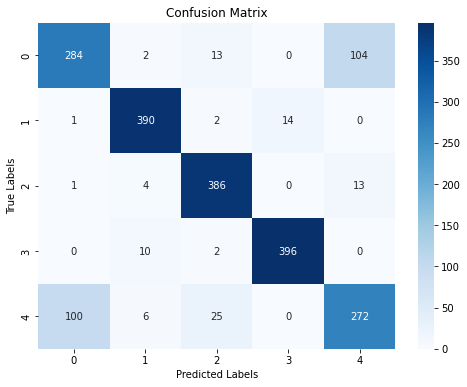

In [20]:
# Plot the confusion matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [23]:
# Save the model in HDF5 format
model_dense.save('densenet201_final.h5')

In [27]:
import shutil
shutil.move('densenet201_final.h5', '/kaggle/working/densenet201.h5')


'/kaggle/working/densenet201.h5'

In [33]:
from IPython.display import FileLink

# Provide a downloadable link for the file
FileLink('/kaggle/working/densenet201_final.h5')


/kaggle/working/densenet201_final.h5